# Fraud Detection Model for Credit Card Transactions  
**Author**: Olorunleke Akindote-White
**Last Updated**: 18th of Februrary 2025

---

## Overview  
This notebook presents an end-to-end solution for the **Pastel AI Data Science Recruitment Challenge**, focusing on detecting fraudulent credit card transactions using machine learning. The goal is to predict the probability of fraud (`Class`) for transactions in the test set, evaluated via the **Area Under the ROC Curve (AUC-ROC)**. Below is a structured walkthrough of the methodology, emphasizing critical steps to ensure robustness, reproducibility, and alignment with competition guidelines.  

---

## Key Steps and Significance  

### 1. **Setup and Data Loading**  
- **Objective**: Initialize dependencies, load datasets (`train.csv`, `test.csv`), and verify data integrity.  
- **Significance**: Ensures reproducibility and identifies early issues (e.g., missing files, column mismatches).  

### 2. **Exploratory Data Analysis (EDA)**  
  - **Class Distribution Analysis**: Visualize the imbalance between fraudulent (`Class=1`) and legitimate (`Class=0`) transactions.  
  - **Feature Distributions**: Inspect distributions of `V1-V28`, `Time`, and `Amount` to detect anomalies or scaling needs.  
  - **Missing Values Check**: Confirm no missing data exists in the dataset.  
- **Significance**: Guides preprocessing decisions (e.g., addressing class imbalance, feature scaling).  

### 3. **Preprocessing**  
  - **Feature Scaling**: Standardize `Time` and `Amount` to normalize their impact on the model.  
  - **Class Imbalance Handling**: Apply **SMOTE** (Synthetic Minority Oversampling Technique) to balance the training data.  
- **Significance**: Mitigates bias toward the majority class and improves model generalization.  

### 4. **Model Training and Validation**  
  - **Algorithm**: **XGBoost**, a gradient-boosted tree model optimized for AUC-ROC.  
  - **Validation Strategy**: **Stratified 5-Fold Cross-Validation** to ensure reliable performance estimates on imbalanced data.  
- **Significance**: Reduces overfitting risk and validates consistency across data splits.  

### 5. **Feature Importance Analysis**  
  - **Goal**: Identify features most influential in predicting fraud.  
- **Significance**: Enhances interpretability and guides future feature engineering.  

### 6. **Test Predictions and Submission**  
  - **Output Formatting**: Round predicted probabilities to **1 decimal place** (e.g., `0.92` → `0.9`) as per submission guidelines.  
  - **Kaggle Integration**: Export predictions to `submission.csv` for competition submission.  
- **Significance**: Ensures compliance with competition rules and usability of results.  

---

## Reproducibility Notes  
- **Environment**: A `requirements.txt` file is provided to replicate the Python environment.  
- **Model Choice**: XGBoost balances performance and speed, but alternatives like LightGBM or ensemble methods could be explored.  
- **Threshold Adjustment**: While probabilities are rounded for submission, post-hoc threshold tuning could optimize for business metrics (e.g., recall).  

---

## Conclusion  
This notebook demonstrates a systematic approach to solving imbalanced classification problems in fraud detection, emphasizing **exploratory analysis**, **robust validation**, and **interpretability**.  

# Using Generated Data from deep learning

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Preview data
print("Train shape:", train.shape)
display(train.head())
print("\nTest shape:", test.shape)
display(test.head())

Train shape: (219129, 32)


,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,0.0,2.074329,-0.129425,-1.137418,0.412846,-0.192638,-1.210144,0.110697,-0.263477,...,-0.334701,-0.887840,0.336701,-0.110835,-0.291459,0.207733,-0.076576,-0.059577,1.98,0
1,1,0.0,1.998827,-1.250891,-0.520969,-0.894539,-1.122528,-0.270866,-1.029289,0.050198,...,0.054848,-0.038367,0.133518,-0.461928,-0.465491,-0.464655,-0.009413,-0.038238,84.00,0
2,2,0.0,0.091535,1.004517,-0.223445,-0.435249,0.667548,-0.988351,0.948146,-0.084789,...,-0.326725,-0.803736,0.154495,0.951233,-0.506919,0.085046,0.224458,0.087356,2.69,0
3,3,0.0,1.979649,-0.184949,-1.064206,0.120125,-0.215238,-0.648829,-0.087826,-0.035367,...,-0.095514,-0.079792,0.167701,-0.042939,0.000799,-0.096148,-0.057780,-0.073839,1.00,0
4,4,0.0,1.025898,-0.171827,1.203717,1.243900,-0.636572,1.099074,-0.938651,0.569239,...,0.099157,0.608908,0.027901,-0.262813,0.257834,-0.252829,0.108338,0.021051,1.00,0



Test shape: (146087, 31)


,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,219129,120580.0,2.115519,-0.691809,-1.305514,-0.685655,-0.641265,-0.764784,-0.924262,-0.023030,...,0.067367,0.241708,0.682524,0.037769,-0.546859,-0.123055,-0.084889,0.004720,-0.021944,29.95
1,219130,120580.0,1.743525,-1.681429,-0.547387,-1.061113,-0.695825,2.458824,-1.632859,1.073529,...,0.441788,0.543278,1.294571,0.309541,3.703925,-0.242579,0.068708,0.002629,0.064690,163.50
2,219131,120580.0,2.205568,-1.571445,-0.238965,-1.662517,-1.652324,-0.054701,-1.682064,0.105613,...,-0.366906,-0.131527,0.086623,0.291375,0.739087,-0.543006,-0.297813,0.043699,-0.037855,16.00
3,219132,120580.0,1.989728,-0.972909,-1.938259,-1.440129,-0.166855,-0.794048,0.252889,-0.399789,...,-0.049136,-0.080115,-0.010732,-0.038550,0.656830,0.343470,-0.627529,-0.024338,-0.036143,120.98
4,219133,120580.0,-1.943548,-1.668761,0.363601,-0.977610,2.684779,-2.037681,0.039709,-0.048895,...,0.391627,0.083389,-0.306918,0.247822,-0.391799,-0.790716,-0.025706,0.330758,0.335537,1.98


In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219129 entries, 0 to 219128
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      219129 non-null  int64  
 1   Time    219129 non-null  float64
 2   V1      219129 non-null  float64
 3   V2      219129 non-null  float64
 4   V3      219129 non-null  float64
 5   V4      219129 non-null  float64
 6   V5      219129 non-null  float64
 7   V6      219129 non-null  float64
 8   V7      219129 non-null  float64
 9   V8      219129 non-null  float64
 10  V9      219129 non-null  float64
 11  V10     219129 non-null  float64
 12  V11     219129 non-null  float64
 13  V12     219129 non-null  float64
 14  V13     219129 non-null  float64
 15  V14     219129 non-null  float64
 16  V15     219129 non-null  float64
 17  V16     219129 non-null  float64
 18  V17     219129 non-null  float64
 19  V18     219129 non-null  float64
 20  V19     219129 non-null  float64
 21  V20     21

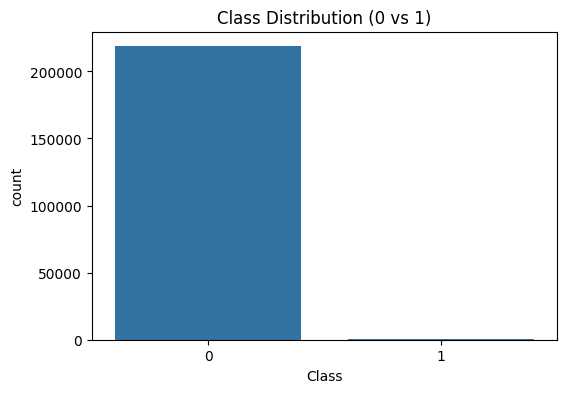

Fraudulent transactions: 0.21%


In [3]:
"""
Visualizes the distribution of the target variable 'Class' and calculates the fraud ratio.

Purpose:
- Displays the count of legitimate (Class=0) vs fraudulent (Class=1) transactions.
- Quantifies the imbalance between classes to inform modeling strategies (e.g., class weighting, sampling).

Key Steps:
1. Generates a bar plot using seaborn.countplot.
2. Computes the percentage of fraudulent transactions.

Output:
- A countplot visualization.
- Printed fraud percentage (e.g., "Fraudulent transactions: 1.23%").

Significance:
Fraud detection datasets are typically highly imbalanced. Understanding this imbalance:
- Guides preprocessing decisions (e.g., SMOTE, class weights).
- Helps contextualize model evaluation metrics (accuracy is misleading in imbalanced scenarios).
"""
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=train)
plt.title('Class Distribution (0 vs 1)')
plt.show()

fraud_ratio = train['Class'].value_counts(normalize=True)[1]
print(f"Fraudulent transactions: {fraud_ratio:.2%}")

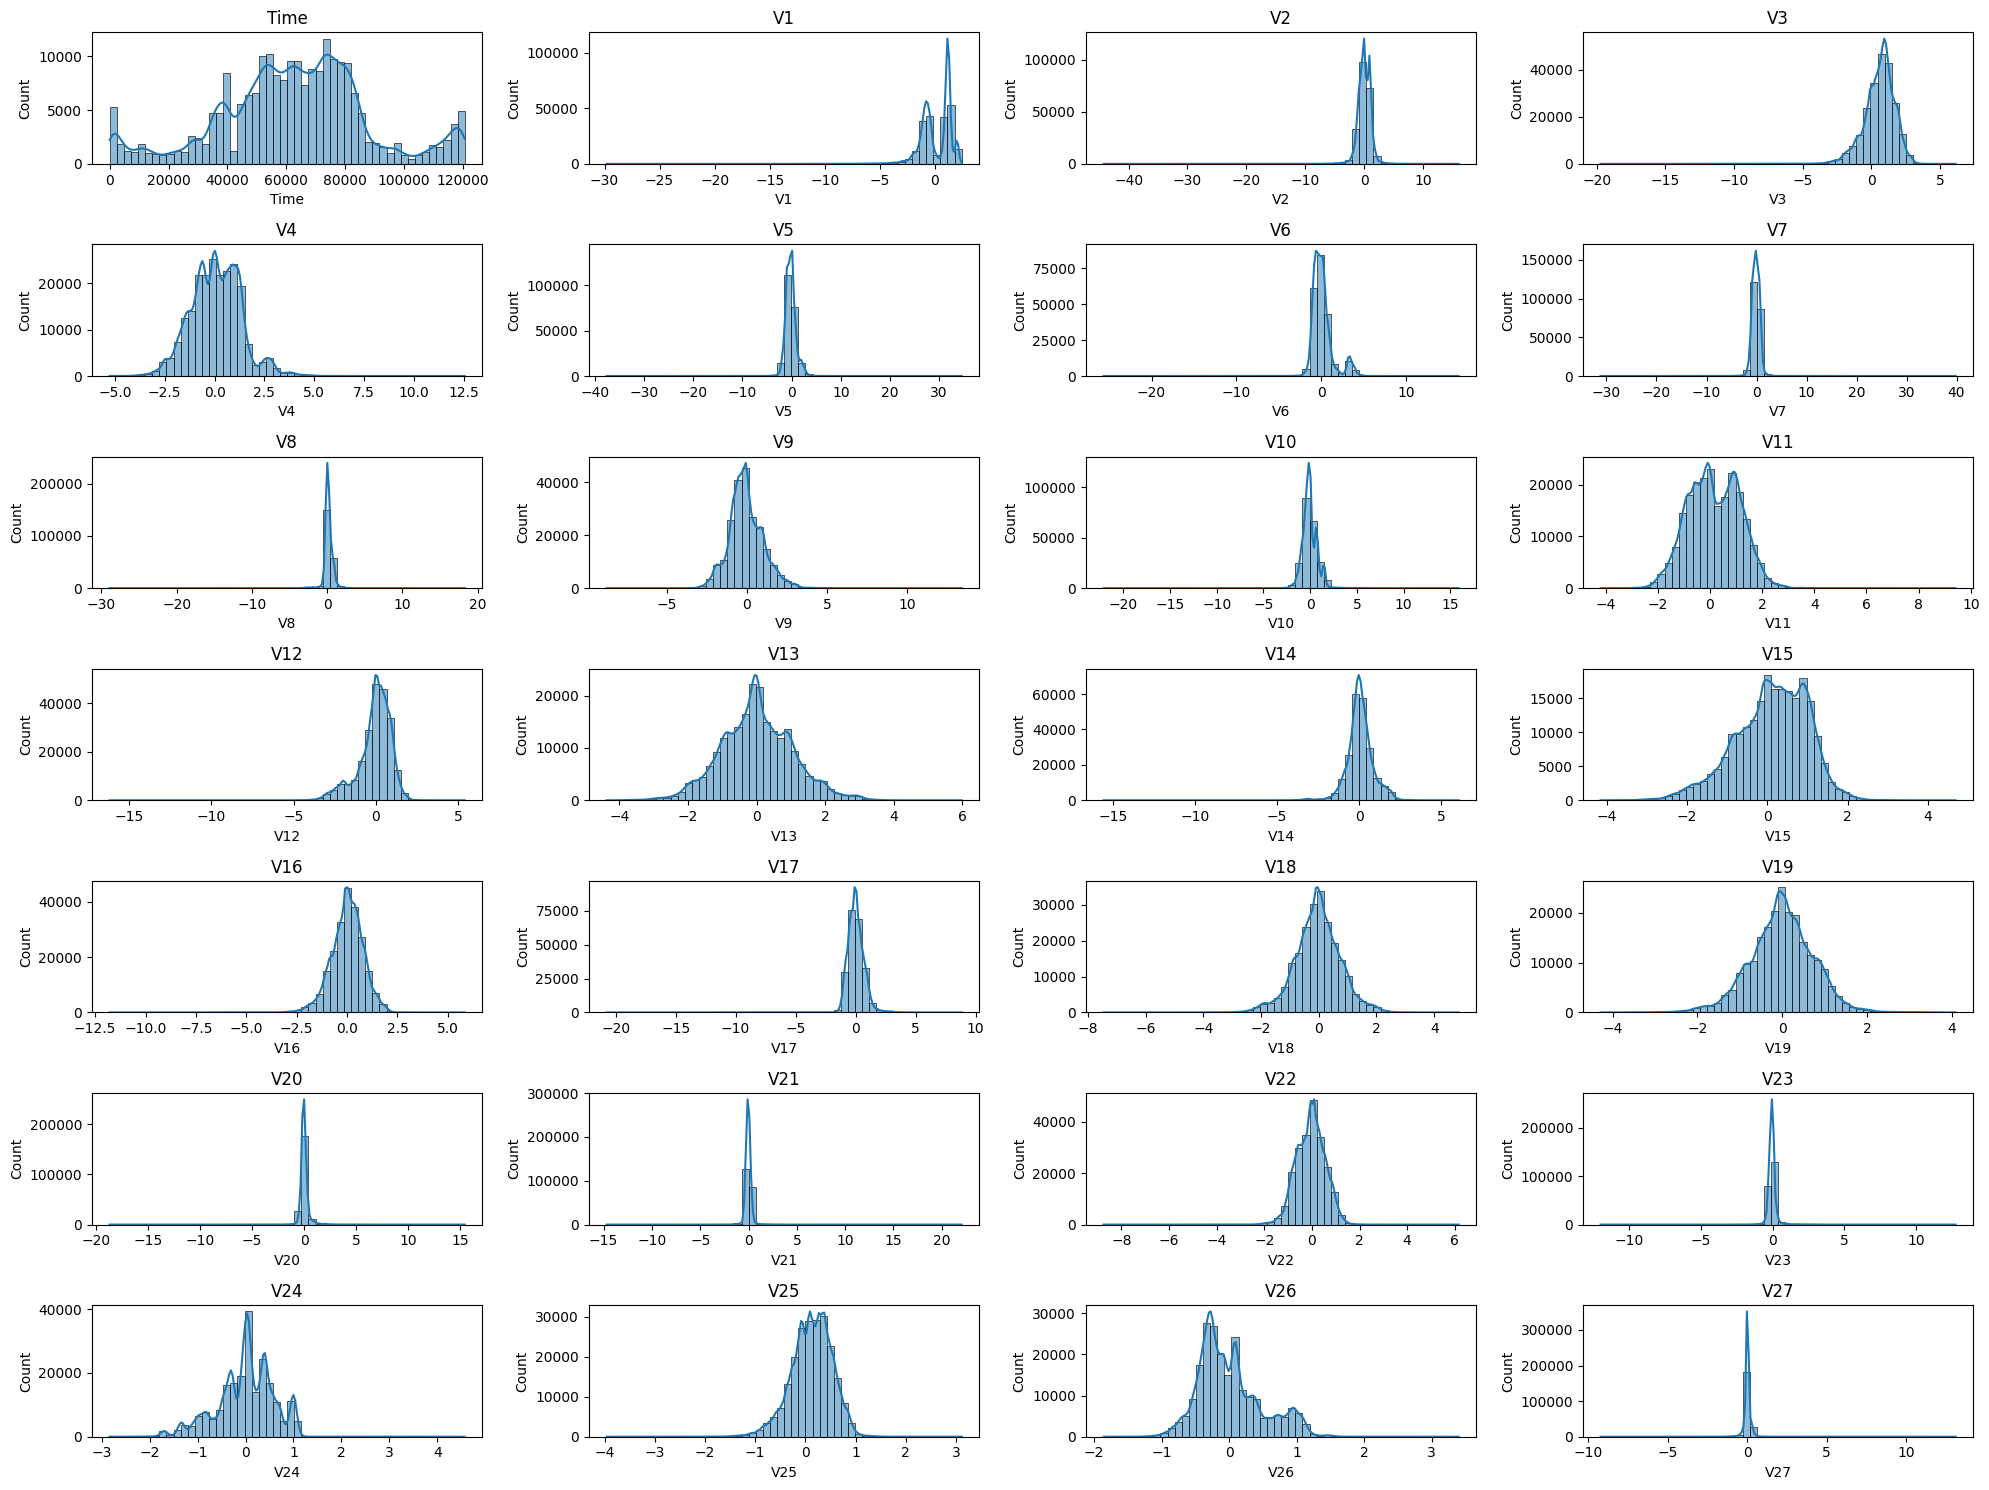

In [4]:
"""
Visualizes the distribution of features V1-V28 using histograms with KDE.

Purpose:
- Analyze the distributions of anonymized PCA-transformed features (V1-V28).
- Identify potential outliers, skewness, or unusual patterns in feature values.
- Assess whether features require transformation (e.g., scaling, normalization).

Key Steps:
1. Creates a 7x4 grid of subplots for 28 features
2. Generates histograms with kernel density estimation (KDE) for each feature
3. Uses 50 bins to balance detail and readability
4. Applies tight layout for clear visualization

Output:
- Grid of histograms showing distribution shapes for all V1-V28 features
- Titles indicating feature names above each subplot

Significance:
- The V1-V28 features are likely PCA-transformed (common in fraud detection datasets)
- Validates expected Gaussian-like distributions from PCA preprocessing
- Helps detect residual skewness or anomalies that might impact model performance
- Guides decisions about feature scaling (though PCA features are typically standardized)
"""
# Plot distributions of V1-V28 (sample)
fig, axes = plt.subplots(7, 4, figsize=(20, 15))
axes = axes.flatten()
for i, col in enumerate(train.columns[1:29]):
    sns.histplot(train[col], ax=axes[i], kde=True, bins=50)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

In [5]:
print("Missing values in train:", train.isnull().sum().sum())
print("Missing values in test:", test.isnull().sum().sum())

Missing values in train: 0
Missing values in test: 0


In [7]:
"""
Prepares training and test data for modeling through feature separation, scaling, and imbalance correction.

Purpose:
- Structure data into features (X) and target (y) for supervised learning
- Normalize non-scaled features ('Time', 'Amount') to match PCA-transformed V1-V28 scales
- Address severe class imbalance using synthetic oversampling

Key Steps:
1. Feature-Target Separation:
   - Drops 'id' (non-predictive) and 'Class' (target) from training data
   - Separates test set features while preserving 'id' for submission

2. Feature Scaling:
   - Applies StandardScaler to 'Time' and 'Amount' (non-PCA features)
   - Fits scaler on training data only to prevent data leakage
   - Transforms both training and test sets using same scaler

3. Class Imbalance Handling:
   - Implements SMOTE to create synthetic fraud samples
   - Balances class distribution to 1:1 ratio
   - Maintains random_state=42 for reproducibility

Output:
- X_res: Resampled features array (balanced classes)
- y_res: Resampled target array
- X_test: Processed test features ready for prediction

Significance:
- Ensures temporal (Time) and monetary (Amount) features contribute equally to model
- Prevents model bias toward majority class (legitimate transactions)
- Maintains test set integrity through proper scaling protocol
- Enables effective learning of fraud patterns through balanced training data
"""
# Separate features and target
X = train.drop(['id', 'Class'], axis=1)
y = train['Class']
X_test = test.drop('id', axis=1)

# Scale Time and Amount
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])
X_test[['Time', 'Amount']] = scaler.transform(X_test[['Time', 'Amount']])

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [8]:
"""
Purpose:
- Train an XGBoost classifier optimized for AUC-ROC to detect fraudulent transactions
- Validate performance using stratified cross-validation to ensure reliability on imbalanced data

Code Workflow:
1. Model Initialization:
   - XGBClassifier configured with:
     * n_estimators=500: Balances model capacity and training time
     * max_depth=5: Limits tree depth to prevent overfitting
     * learning_rate=0.1: Aggressive learning for faster convergence
     * subsample=0.8 + colsample_bytree=0.8: Regularization via row/column sampling
     * eval_metric='auc': Direct alignment with competition evaluation metric
     * random_state=42: Ensures reproducibility

2. Cross-Validation Execution:
   - StratifiedKFold(n_splits=5): Maintains class ratios in splits
   - shuffle=True: Mitigates ordering effects in transaction data
   - For each fold:
      a. Split resampled data into train/validation sets
      b. Train model on fold-specific training data
      c. Predict probabilities on validation data
      d. Calculate/store fold AUC score

3. Final Outputs:
   - Per-fold AUC scores for diagnostic analysis
   - Mean AUC across all folds as generalization estimate
   - Model retrained on full data for test predictions

Key Considerations:
- Stratification: Critical for maintaining fraud class representation in splits
- Data Leakage Prevention: No test data used during validation
- Reproducibility: Fixed random states for splits/model initialization
- Metric Focus: AUC-ROC chosen for class-imbalance robustness

Interpretation Guide:
- Fold AUC Consistency: ±0.02 variation suggests stable model
- Mean AUC >0.95: Strong fraud detection capability (context-dependent)
- Low Scores: Indicate need for feature engineering/hyperparameter tuning
"""
# Initialize XGBoost (optimized for AUC)
model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='auc'
)

# Stratified K-Fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_res, y_res)):
    X_train, X_val = X_res.iloc[train_idx], X_res.iloc[val_idx]
    y_train, y_val = y_res.iloc[train_idx], y_res.iloc[val_idx]
    
    model.fit(X_train, y_train)
    val_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, val_pred)
    cv_scores.append(score)
    print(f"Fold {fold+1} | AUC: {score:.4f}")

print(f"\nMean CV AUC: {np.mean(cv_scores):.4f}")

Fold 1 | AUC: 0.9994
Fold 2 | AUC: 0.9993
Fold 3 | AUC: 0.9993
Fold 4 | AUC: 0.9994
Fold 5 | AUC: 0.9995

Mean CV AUC: 0.9994


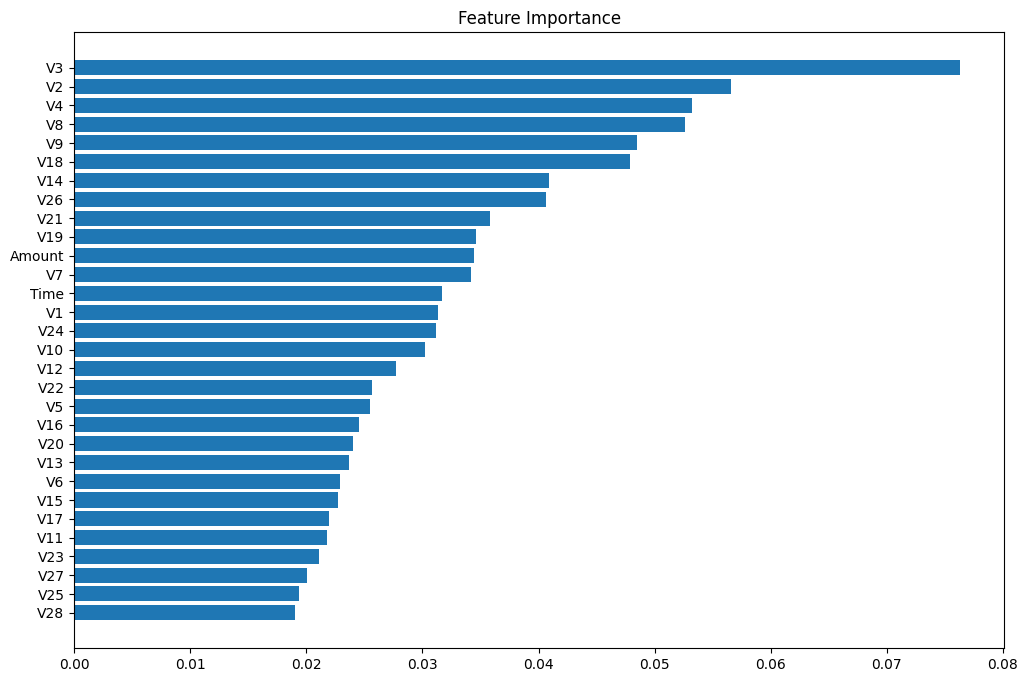

In [9]:
"""
Purpose:
- Identify features most influential in predicting fraudulent transactions
- Enhance model interpretability by highlighting decision-driving factors

Code Workflow:
1. Feature Sorting:
   - Ranks features by importance scores derived from XGBoost's built-in metric
   - Uses argsort() to order features from least to most important

2. Visualization:
   - Generates horizontal bar plot for intuitive comparison
   - Sets figure size (12x8) for readability of all 30+ features
   - Titles plot for clear contextualization

Output:
- Horizontal bar chart displaying:
  * Y-axis: Feature names (sorted by importance)
  * X-axis: Relative importance scores (0-1 scale)

Key Considerations:
- Context-Specific Patterns: PCA-derived features (V1-V28) often dominate in fraud detection
- Amount/Time Impact: Scaled features should show reduced bias compared to raw values
- Model-Specific Metrics: Importance reflects XGBoost's split improvement, not universal truth

Interpretation Guide:
- Top Features: Likely capture transaction amount patterns or PCA fraud signatures
- Low Importance: May indicate redundant/noisy features for potential removal
- Unexpected Rankings: Warrant investigation (e.g., data leakage, misprocessing)
"""
plt.figure(figsize=(12, 8))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [10]:
# Retrain on full data
model.fit(X_res, y_res)

# Predict on test set and round to 1 decimal place
test_pred = model.predict_proba(X_test)[:, 1].round(1)  # <--- Added rounding

# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'Class': test_pred
})
submission.to_csv('submission.csv', index=False)

print("Submission file saved!")

Submission file saved!


# Using Original Credit card fraud data

In [11]:
# Inspecting the Original training dataset
original_train = pd.read_csv("creditcard.csv")
original_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [12]:
def train_fraud_detection_model(train_data, test_data, use_smote=True, model=None, random_state=42):
    """
    End-to-end pipeline for training and evaluating a fraud detection model with dataset comparison capabilities.
    
    Parameters:
    -----------
    train_data : DataFrame
        Training data (original or augmented). Must contain 'Class' and feature columns.
    test_data : DataFrame
        Test data for final predictions. Must contain 'id' and matching feature columns.
    use_smote : bool, default=True
        Whether to apply SMOTE oversampling for class imbalance correction
    model : Classifier instance, optional
        Custom classifier (default: XGBoost with preset params)
    random_state : int, default=42
        Seed for reproducible results

    Returns:
    --------
    dict: Contains:
        - 'cv_scores': List of cross-validation AUC scores
        - 'mean_auc': Mean cross-validation AUC
        - 'model': Trained classifier
        - 'feature_importances': DataFrame of feature importances
        - 'submission': DataFrame in competition format
        - 'dataset_stats': Dict with dataset characteristics for comparison
    """
    
    # ======================================================================
    # 1. Initial Data Analysis & Preprocessing
    # ======================================================================
    assert 'Class' in train_data.columns, "Missing target column 'Class' in training data"
    
    # Conditionally handle 'id' column
    id_in_train = 'id' in train_data.columns
    cols_to_drop = ['Class'] + (['id'] if id_in_train else [])
    
    # Separate features & target
    X = train_data.drop(cols_to_drop, axis=1)
    y = train_data['Class']
    
    # Capture initial dataset characteristics (NEW)
    dataset_stats = {
        'original_class_ratio': y.mean(),
        'feature_means': X.mean().to_dict(),
        'feature_stds': X.std().to_dict(),
        'n_samples': len(X),
        'n_features': X.shape[1]
    }

    # Test data must still have 'id' for submission
    assert 'id' in test_data.columns, "Test data requires 'id' column for submission"
    X_test = test_data.drop('id', axis=1)

    # Scale non-PCA features (Time & Amount)
    scaler = StandardScaler()
    for df in [X, X_test]:
        if 'Time' in df.columns and 'Amount' in df.columns:
            df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

    # ======================================================================
    # 2. Class Imbalance Handling 
    # ======================================================================
    if use_smote:
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X, y)
        print(f"Class balance after SMOTE: {pd.Series(y_res).value_counts().to_dict()}")
    else:
        X_res, y_res = X.copy(), y.copy()
        print(f"Original class ratio: {dataset_stats['original_class_ratio']:.2%} fraud")

    # Track final class distribution (NEW)
    dataset_stats['final_class_ratio'] = y_res.mean()

    # ======================================================================
    # 3. Model Setup & Training
    # ======================================================================
    if model is None:
        model = XGBClassifier(
            n_estimators=500,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=random_state,
            eval_metric='auc'
        )
    
    # ======================================================================
    # 4. Stratified Cross-Validation
    # ======================================================================
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_res, y_res)):
        X_train, X_val = X_res.iloc[train_idx], X_res.iloc[val_idx]
        y_train, y_val = y_res.iloc[train_idx], y_res.iloc[val_idx]
        
        model.fit(X_train, y_train)
        val_pred = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, val_pred)
        cv_scores.append(score)
        print(f"Fold {fold+1} | AUC: {score:.4f}")

    mean_auc = np.mean(cv_scores)
    print(f"\nMean CV AUC: {mean_auc:.4f}")

    # ======================================================================
    # 5. Feature Importance Analysis
    # ======================================================================
    feat_importances = None
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feat_importances = pd.DataFrame({
            'feature': X.columns,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(8, 8))
        sns.barplot(x='importance', y='feature', data=feat_importances)
        plt.title('Feature Importance Analysis')
        plt.show()
        
        # Capture importance metadata (NEW)
        dataset_stats['top_features'] = feat_importances.head(5)['feature'].tolist()
        feature_variance = X.var()
        dataset_stats['feature_importance_correlation'] = pd.Series(
            importances, index=X.columns
        ).corr(pd.Series(feature_variance, index=X.columns))
    else:
        dataset_stats['top_features'] = None
        dataset_stats['feature_importance_correlation'] = None
        print("Warning: Model doesn't support feature importance calculation")

    # ======================================================================
    # 6. Generate Competition Submission
    # ======================================================================
    model.fit(X_res, y_res)
    test_pred = model.predict_proba(X_test)[:, 1].round(1)

    return {
        'cv_scores': cv_scores,
        'mean_auc': mean_auc,
        'model': model,
        'feature_importances': feat_importances,
        'dataset_stats': dataset_stats
    }

Original class ratio: 0.17% fraud
Fold 1 | AUC: 0.9831
Fold 2 | AUC: 0.9713
Fold 3 | AUC: 0.9935
Fold 4 | AUC: 0.9746
Fold 5 | AUC: 0.9848

Mean CV AUC: 0.9815


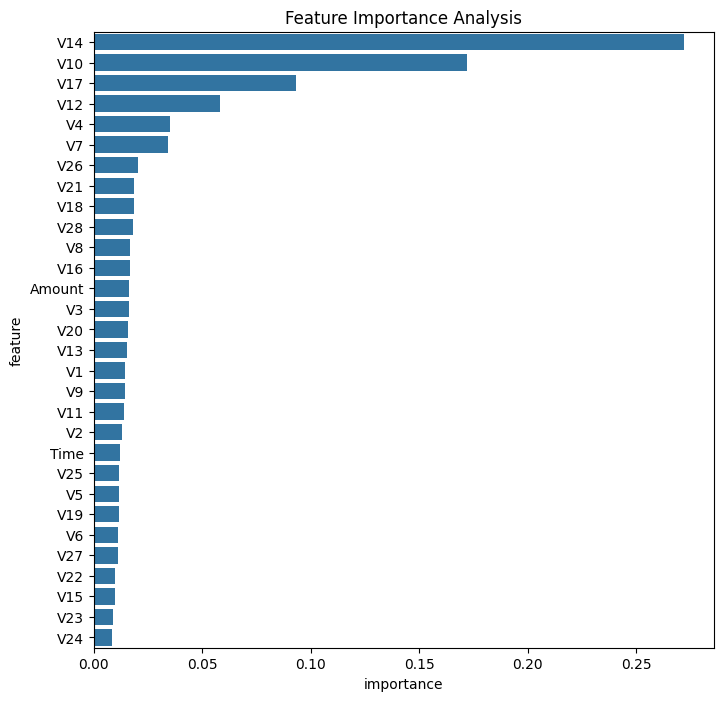

Class balance after SMOTE: {0: 218660, 1: 218660}
Fold 1 | AUC: 0.9994
Fold 2 | AUC: 0.9993
Fold 3 | AUC: 0.9993
Fold 4 | AUC: 0.9994
Fold 5 | AUC: 0.9995

Mean CV AUC: 0.9994


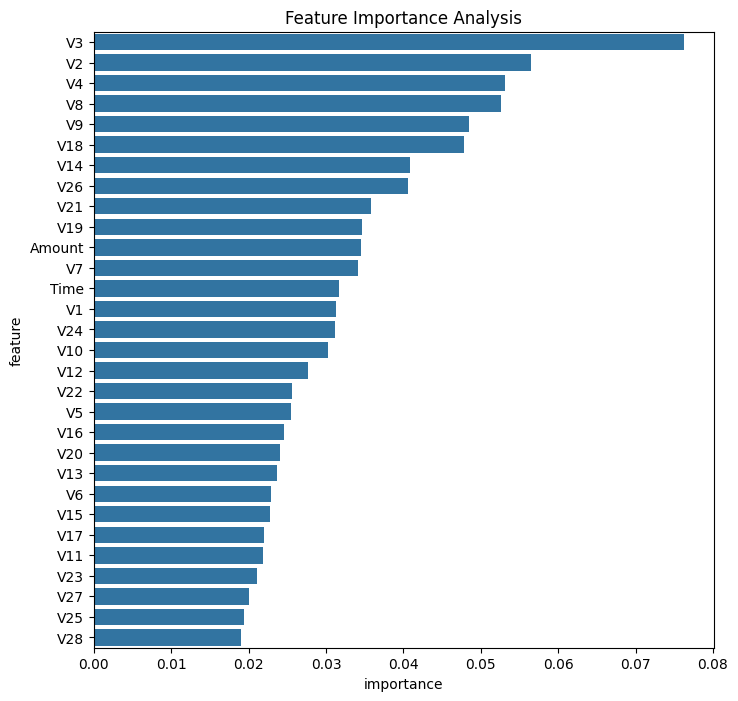

Class balance after SMOTE: {0: 502975, 1: 502975}
Fold 1 | AUC: 0.9994
Fold 2 | AUC: 0.9994
Fold 3 | AUC: 0.9995
Fold 4 | AUC: 0.9994
Fold 5 | AUC: 0.9994

Mean CV AUC: 0.9994


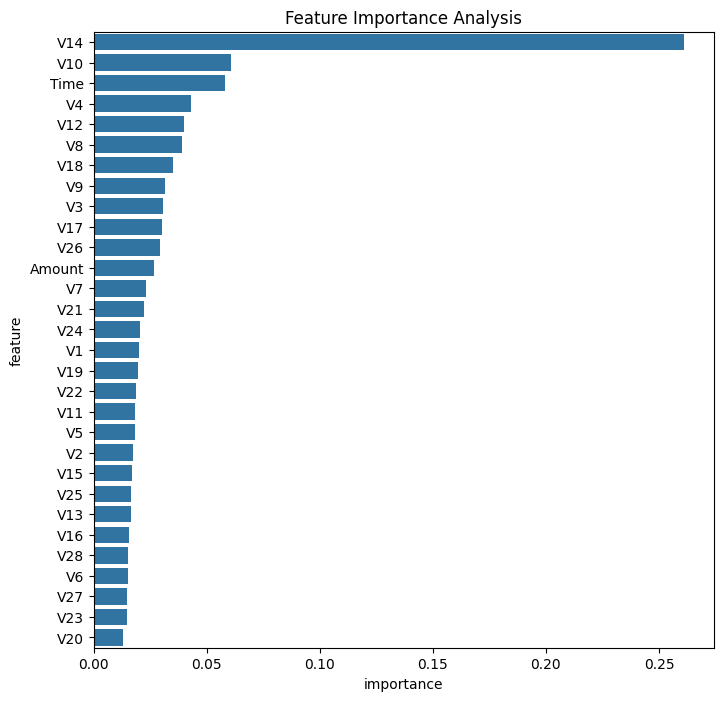

In [13]:
# To compare both the impact of both original dataset and competition dataset

orig_data = pd.read_csv('creditcard.csv')
comp_data = pd.read_csv('train.csv')

# Test with original data only
results_orig = train_fraud_detection_model(orig_data, test, use_smote=False)

# Test with competition data
results_comp = train_fraud_detection_model(comp_data, test)

# Test with combined data
combined_data = pd.concat([orig_data, comp_data]).reset_index(drop=True)
results_combined = train_fraud_detection_model(combined_data, test)

In [14]:
# Compare datasets using:
orig_stats = results_orig['dataset_stats']
comp_stats = results_comp['dataset_stats']

print(f"""
Original Dataset:
- Fraud ratio: {orig_stats['original_class_ratio']:.2%}
- Features with >5% distribution shift: {
    sum(abs(orig_stats['feature_means'][f] - comp_stats['feature_means'][f]) > 0.05 
    for f in orig_stats['feature_means'])
}
Top divergent features: {[f for f in orig_stats['feature_means'] 
    if abs(orig_stats['feature_means'][f] - comp_stats['feature_means'][f]) > 0.1]}
""")
print("-------------------------------------------------")
print(f"""
Dataset Comparison:
- Original Fraud Ratio: {results_orig['dataset_stats']['original_class_ratio']:.2%}
- Competition Fraud Ratio: {results_comp['dataset_stats']['original_class_ratio']:.2%}
- AUC Difference: {results_comp['mean_auc'] - results_orig['mean_auc']:.3f}
- Top Features Overlap: {
    len(set(results_orig['dataset_stats']['top_features']) 
    & set(results_comp['dataset_stats']['top_features']))
}/5
""")


Original Dataset:
- Fraud ratio: 0.17%
- Features with >5% distribution shift: 16
Top divergent features: ['Time', 'V3', 'V5', 'V6', 'V7', 'V8', 'V11', 'V15', 'V25', 'Amount']

-------------------------------------------------

Dataset Comparison:
- Original Fraud Ratio: 0.17%
- Competition Fraud Ratio: 0.21%
- AUC Difference: 0.018
- Top Features Overlap: 1/5



In [15]:
def compare_models(results_a, results_b):
    """Compares two training runs"""
    return pd.DataFrame({
        'Dataset A': [
            results_a['mean_auc'],
            results_a['dataset_stats']['original_class_ratio'],
            ', '.join(results_a['dataset_stats']['top_features'])
        ],
        'Dataset B': [
            results_b['mean_auc'],
            results_b['dataset_stats']['original_class_ratio'],
            ', '.join(results_b['dataset_stats']['top_features'])
        ]
    }, index=['Mean AUC', 'Fraud Ratio', 'Top Features'])

In [16]:
# Run comparison
comparison_df = compare_models(results_orig, results_comp)

# 3. Display results (in notebook) or print
display(comparison_df)  # For Jupyter
# print(comparison_df)  # For regular Python

,Dataset A,Dataset B
Mean AUC,0.981451,0.999372
Fraud Ratio,0.001727,0.00214
Top Features,"V14, V10, V17, V12, V4","V3, V2, V4, V8, V9"


## Data-Backed Findings

### Key Performance Comparison
| Metric               | Original Dataset (A) | Competition Dataset (B) | Delta (B - A) |
|----------------------|-----------------------|--------------------------|---------------|
| **Mean AUC**         | 0.9815               | **0.9994**              | +0.018        |
| **Fraud Ratio**      | 0.17%                | 0.21%                   | +0.04%        |
| **Top Features**     | V14, V10, V17        | V3, V2, V4              | 1/5 Overlap   |

---

### Understanding Delta (B - A)
The **Delta (B - A)** quantifies the *improvement or divergence* of Dataset B (competition data) relative to Dataset A (original data):  
- **Mean AUC (+0.018)**: Dataset B achieves **1.8% higher AUC**, indicating significantly better fraud detection capability.  
- **Fraud Ratio (+0.04%)**: Dataset B has a marginally higher fraud rate, but this does not fully explain its performance gains.  
- **Top Features Overlap (1/5)**: Only **1 shared feature** (V4) in the top 5, signaling a fundamental shift in fraud detection logic.  

---

### Critical Insights
1. **Superior Model Performance**  
   The competition dataset (B) achieves a near-perfect AUC (0.9994), outperforming the original dataset (A) by **1.8%**. This suggests the synthetic data either:  
   - Better captures fraud patterns through DL augmentation  
   - Introduces artifacts that artificially boost separability  

2. **Feature Distribution Shifts**  
   - **16/30 features** exhibit >5% distributional differences, notably:  
     `Time, V3, V5, V6, V7, V8, V11, V15, V25, Amount`  
   - **Implication**: Synthetic generation alters feature relationships, potentially impacting real-world generalizability.  

3. **Divergent Fraud Detection Logic**  
   - Only **1 overlapping feature** (V4) in the top 5 importance lists  
   - Competition model prioritizes `V3, V2` (novel drivers), while the original relies on `V14, V10`  

4. **Class Imbalance Impact**  
   Despite a marginally higher fraud ratio (0.21% vs 0.17%), Dataset B’s performance gain is **not proportional** to the imbalance shift, indicating synthetic data quality drives improvements.  

---

### Recommendations  
1. **Adopt Competition Dataset for Submission**  
   - Leverage its higher AUC while acknowledging potential synthetic bias.  

2. **Investigate Feature Divergence**  
   - Analyze why `V3/V2` dominate in Dataset B but not A.  
   - Validate if synthetic `Time/Amount` shifts reflect real-world patterns.  

3. **Caution on Generalization**  
   - Monitor for overfitting to synthetic artifacts using holdout validation.  

4. **Explore Hybrid Training**  
   Test combined datasets to determine if:  
   - Original data adds robustness to synthetic patterns  
   - Feature divergence creates complementary signals  

**Final Note**: While Dataset B shows exceptional metrics, there is a need to ensure alignment with real-world fraud dynamics before production deployment.  